In [1]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display
pd.options.display.precision = 15
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from numba import jit
import random

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

### 앙상블 : 배깅과 부스팅

### 배깅 : 많은 강력한 학습자를 사용하고 결과를 평균화
### 부스팅 : 약한 학습자를 사용하고 오류를 계속 개선

- GBM : 효율성 문제가 있음
- XGB : GBM의 효율성 문제를 개선
- lightGBM : XGB의 속도 문제를 개선했으나 데이터가 적으면 과적합을 하는 단점이 있음

In [3]:
# 랜덤 생성기
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
seed = 42
seed_everything(seed)

In [4]:
# 데이터를 가져온다
train_identity = pd.read_csv('train_identity3.csv')
train_transaction = pd.read_csv('train_transaction3.csv')
test_identity = pd.read_csv('test_identity3.csv')
test_transaction = pd.read_csv('test_transaction3.csv')
sub = pd.read_csv('sample_submission3.csv')

In [5]:
# train_identity 상위 5개를 보자
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
3    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   
4    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
2  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
3  176.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
4  529.0  575.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found               NaN          chrome 62.0    NaN        NaN   
3  NotFound               NaN          chrome 62.0    NaN        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows  
3                            NaN  
4                          MacOS

In [6]:
# train_identity 표 모양을 보자
train_identity.shape

(144233, 41)

In [7]:
# train_transaction 상위 5개를 보자
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

In [8]:
# train_transaction 표 모양을 보자
train_transaction.shape

(590540, 394)

In [9]:
# test_identity 상위 5개를 보자
test_identity.head()

TransactionID  id-01     id-02  id-03  id-04  id-05  id-06  id-07  id-08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   
2        3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN    NaN   
3        3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    NaN    NaN   
4        3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN    NaN   

   id-09  id-10  id-11     id-12  id-13  id-14  id-15     id-16  id-17  id-18  \
0    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   
1    0.0    0.0  100.0     Found    NaN -300.0  Found     Found  166.0    NaN   
2    NaN    NaN  100.0  NotFound   52.0 -360.0    New  NotFound  225.0    NaN   
3    0.0    0.0  100.0  NotFound   27.0    NaN  Found     Found  225.0   15.0   
4    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   

   id-19  id-20  id-21  id-22 id-23  id-24  id-25  id-26 id-27  id-28  \
0  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  542.0  368.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
2  271.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
3  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
4  567.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   

      id-29          id-30                    id-31  id-32     id-33  \
0  NotFound            NaN  chrome 67.0 for android    NaN       NaN   
1     Found  Android 6.0.1  chrome 67.0 for android   24.0  1280x720   
2  NotFound            NaN       ie 11.0 for tablet    NaN       NaN   
3     Found            NaN  chrome 67.0 for android    NaN       NaN   
4  NotFound            NaN  chrome 67.0 for android    NaN       NaN   

            id-34 id-35 id-36 id-37 id-38 DeviceType  \
0             NaN     F     F     T     F     mobile   
1  match_status:2     T     F     T     T     mobile   
2             NaN     F     T     T     F    desktop   
3             NaN     F     F     T     F     mobile   
4             NaN     F     F     T     F     mobile   

                    DeviceInfo  
0  MYA-L13 Build/HUAWEIMYA-L13  
1         LGLS676 Build/MXB48T  
2                  Trident/7.0  
3  MYA-L13 Build/HUAWEIMYA-L13  
4         SM-G9650 Build/R16NW

In [10]:
# test_transaction 상위 5개를 보자
test_transaction.head()

TransactionID  TransactionDT       TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224   31.949999999999999         W  10409  111.0   
1        3663550       18403263   49.000000000000000         W   4272  111.0   
2        3663551       18403310  171.000000000000000         W   4476  574.0   
3        3663552       18403310  284.949999999999989         W  10989  360.0   
4        3663553       18403317   67.950000000000003         W  18018  452.0   

   card3       card4  card5  card6  addr1  addr2   dist1  dist2 P_emaildomain  \
0  150.0        visa  226.0  debit  170.0   87.0     1.0    NaN     gmail.com   
1  150.0        visa  226.0  debit  299.0   87.0     4.0    NaN       aol.com   
2  150.0        visa  226.0  debit  472.0   87.0  2635.0    NaN   hotmail.com   
3  150.0        visa  166.0  debit  205.0   87.0    17.0    NaN     gmail.com   
4  150.0  mastercard  117.0  debit  264.0   87.0     6.0    NaN     gmail.com   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0   
1           NaN  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0  1.0   
2           NaN  2.0  2.0  0.0  0.0  0.0  5.0  0.0  0.0  4.0  0.0  2.0  0.0   
3           NaN  5.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  2.0  0.0   
4           NaN  6.0  6.0  0.0  0.0  2.0  5.0  0.0  0.0  5.0  0.0  6.0  0.0   

     C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9    D10    D11  \
0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN NaN  418.0  203.0   
1   12.0  2.0  149.0  149.0   7.0  634.0   7.0 NaN NaN NaN NaN  231.0  634.0   
2   22.0  2.0  137.0  137.0  10.0   97.0  10.0 NaN NaN NaN NaN  136.0  136.0   
3    7.0  4.0   42.0   42.0  41.0  242.0  41.0 NaN NaN NaN NaN  242.0  242.0   
4   14.0  6.0   22.0   22.0   0.0   22.0   0.0 NaN NaN NaN NaN   22.0   22.0   

   D12  D13  D14    D15 M1 M2 M3   M4   M5 M6   M7   M8   M9   V1   V2   V3  \
0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  F    T    T    T  1.0  1.0  1.0   
1  NaN  NaN  NaN  634.0  T  F  F   M0  NaN  F  NaN  NaN  NaN  1.0  1.0  1.0   
2  NaN  NaN  NaN   97.0  T  T  F   M0    F  F    F    F    F  1.0  1.0  1.0   
3  NaN  NaN  NaN  242.0  T  T  T  NaN  NaN  T  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN   22.0  T  T  T  NaN  NaN  F    F    T    T  1.0  1.0  1.0   

    V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
4  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   

   V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  \
0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
1  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
2  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
3  0.0  2.0  2.0  2.0  2.0  0.0  0.0  1.0  0.0  0.0  2.0  2.0  2.0  2.0  1.0   
4  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   

   V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  \
0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1

In [11]:
# test_identity는 언더바 대신 하이픈을 썻기에 변경
test_identity.columns = [col.replace('-', '_') for col in test_identity.columns]

# 트랜잭션(거래)와 아이덴티티(신분)의 파일을 합친다
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [12]:
# 무거운 원본 데이터 해제
del train_transaction, train_identity, test_transaction, test_identity

In [13]:
# 테스트 데이터만 빈값으로 되어있는 부분은 0으로 채운다
test[[f'C{i}' for i in range(1,15)]] = test[[f'C{i}' for i in range(1,15)]].fillna(0)

In [14]:
# 램 사용량 체크
end_mem = train.memory_usage().sum() / 1024 ** 2 + test.memory_usage().sum() / 1024 ** 2
print(f'Mem. usage {end_mem:5.2f} Mb')

Mem. usage 3637.61 Mb


In [15]:
# 메모리 절약하기
def reduce_mem_usage(memory_df, verbose=True):
    numerics = ['int16','int32','int64','float16','float32','float64']
    start_mem = memory_df.memory_usage().sum() / 1024 ** 2
    for col in memory_df.columns:
        col_type = memory_df[col].dtypes
        if col_type in numerics:
            c_min = memory_df[col].min()
            c_max = memory_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    memory_df[col] = memory_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    memory_df[col] = memory_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    memory_df[col] = memory_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    memory_df[col] = memory_df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    memory_df[col] = memory_df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    memory_df[col] = memory_df[col].astype(np.float32)
                else:
                    memory_df[col] = memory_df[col].astype(np.float64)
    end_mem = memory_df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100*(start_mem - end_mem)/start_mem))
    return memory_df

In [16]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


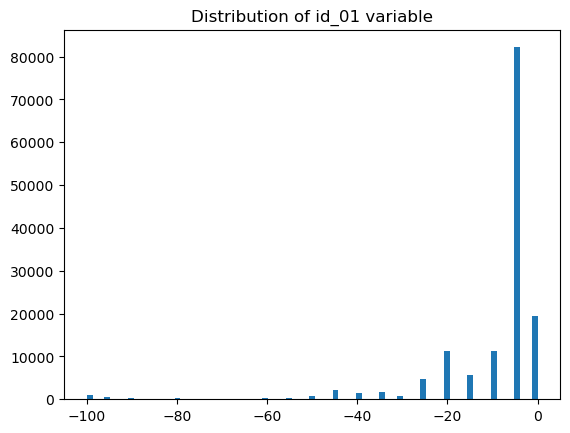

In [17]:
plt.hist(train['id_01'], bins=77);
plt.title('Distribution of id_01 variable');

In [18]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689233582822
0.0    0.108211128797372
1.0    0.001461374335354
3.0    0.001131168083449
2.0    0.000712906831036
Name: id_03, dtype: float64

In [19]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

NaN         0.761272733430420
100.0000    0.225491922647069
95.0625     0.002111626646798
95.1875     0.001359772411691
97.1250     0.000956751447827
Name: id_11, dtype: float64

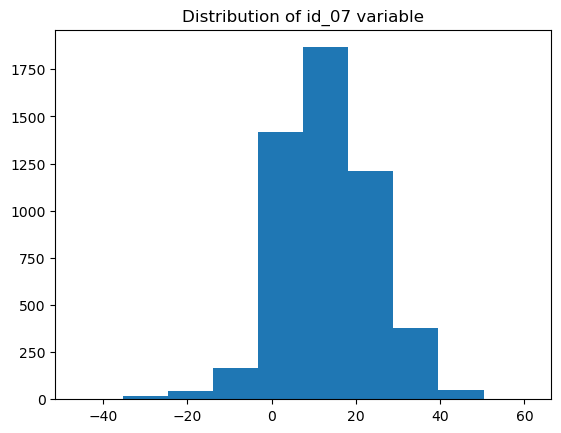

In [20]:
plt.hist(train['id_07']);
plt.title('Distribution of id_07 variable');

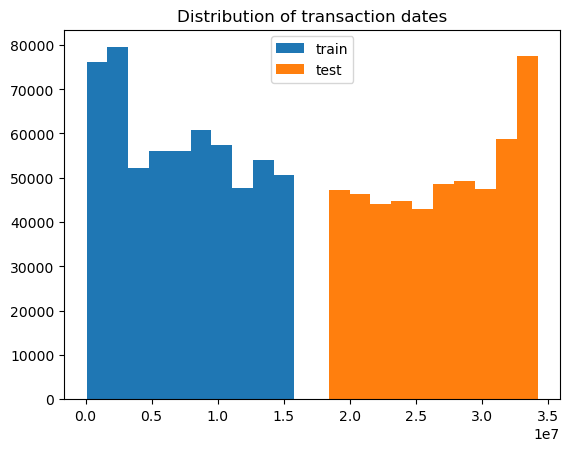

In [21]:
plt.hist(train['TransactionDT'], label='train')
plt.hist(test['TransactionDT'], label='test')
plt.legend();
plt.title('Distribution of transaction dates');

In [22]:
start_date = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [23]:
# 각 컬럼에 NULL 값이 얼마나 있는지 검사한다
for col in train.columns:
    if 'card' in col:
        print(f'{col} has {train[col].isnull().sum()} missing values.')

card1 has 0 missing values.
card2 has 8933 missing values.
card3 has 1565 missing values.
card4 has 1577 missing values.
card5 has 4259 missing values.
card6 has 1571 missing values.


In [24]:
group_with_mode = train.groupby(['card1']).agg({'card2':['nunique', pd.Series.mode]})
group_with_mode.head(10)

card2       
      nunique   mode
card1               
1000        1  555.0
1001        1  555.0
1004        1  583.0
1005        1  543.0
1006        1  399.0
1007        1  555.0
1008        1  555.0
1009        1  399.0
1010        1  555.0
1011        1  543.0

In [25]:
for card in ['card2','card3','card4','card5','card6']:
    group_with_mode = train.groupby(['card1']).agg({card:['nunique', pd.Series.mode]})
    to_merge = group_with_mode[group_with_mode[card]['nunique'] == 1][card]['mode']
    merged = pd.merge(train['card1'], to_merge, on='card1', how='left')
    merged['mode'] = merged['mode'].fillna(train[card])
    train[card] = merged['mode']
    
    group_with_mode = test.groupby(['card1']).agg({card: ['nunique', pd.Series.mode]})
    to_merge = group_with_mode[group_with_mode[card]['nunique'] == 1][card]['mode']
    merged = pd.merge(test['card1'], to_merge, on='card1', how='left')
    merged['mode'] = merged['mode'].fillna(test[card])
    test[card] = merged['mode']

In [26]:
for df in [train, test]:
    df['DaysFromStart'] = np.floor(df['TransactionDT']/(60*60*24)) -1
    df['D1-DaysFromStart'] = df['D1'] - df['DaysFromStart']

In [27]:
for df in [train, test]:
    df['uid'] = df['ProductCD'].astype(str) + '_' + df['card1'].astype(str) + '_' + df['card2'].astype(str)
    df['uid'] = df['uid'] + '_' + df['card3'].astype(str) + '_' + df['card4'].astype(str)
    df['uid'] = df['uid'] + '_' + df['card5'].astype(str) + '_' + df['card6'].astype(str)
    df['uid'] = df['uid'] + '_' + df['addr1'].astype(str) + '_' + df['D1-DaysFromStart'].astype(str)

In [28]:
len(set(train['uid']).intersection(set(test['uid']))), train.uid.nunique(), test.uid.nunique()

(26891, 231339, 205162)

In [29]:
train['DeviceInfo'].value_counts(dropna=False, normalize=True).head(20)

NaN                            0.799055102109933
Windows                        0.080810783350831
iOS Device                     0.033498154231720
MacOS                          0.021290683103600
Trident/7.0                    0.012598638534223
rv:11.0                        0.003219087614726
rv:57.0                        0.001629017509398
SM-J700M Build/MMB29K          0.000929657601517
SM-G610M Build/MMB29K          0.000780641446811
SM-G531H Build/LMY48B          0.000694279811698
rv:59.0                        0.000612998272767
SM-G935F Build/NRD90M          0.000565584041725
SM-G955U Build/NRD90M          0.000555423849358
SM-G532M Build/MMB29T          0.000535103464626
ALE-L23 Build/HuaweiALE-L23    0.000528330003048
SM-G950U Build/NRD90M          0.000491075964372
SM-G930V Build/NRD90M          0.000463982118061
rv:58.0                        0.000455515291090
rv:52.0                        0.000433501540963
SAMSUNG                        0.000397940867680
Name: DeviceInfo, dt

In [30]:
# 해당 커럶의 고유한 값 갯수 조사
train['DeviceInfo'].nunique()

1786

In [31]:
for df in [train, test]:
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))

In [32]:
df['DeviceInfo_device'].value_counts(dropna=False, normalize=True).head(20)

unknowndevice          0.772924721378513
windows                0.088787841110262
iosdevice              0.036945594060285
macos                  0.022003548513788
trident                0.009650852294594
rv                     0.005549733466748
smgu                   0.001569003593906
smgmbuildmmbt          0.001310463379061
motog                  0.001036134448806
smgf                   0.001018372143969
smjm                   0.000972979587165
smgfbuildrnw           0.000943375745770
smgm                   0.000937454977491
motogplus              0.000799303717650
samsungsmgubuildrnw    0.000785488591666
smgubuildrnw           0.000742069624288
smgmbuildmmbk          0.000724307319451
motogplay              0.000722333730025
motoebuildnma          0.000712465782893
smaf                   0.000645363742399
Name: DeviceInfo_device, dtype: float64

In [33]:
df['DeviceInfo_version'].value_counts(dropna=False, normalize=True).head(20)

         0.923432624617370
70       0.009688350493693
3        0.002105819917859
53229    0.001722943569158
5        0.001636105634400
110      0.001482165659149
95016    0.001456508996607
610      0.001328225683898
4        0.001322304915619
33       0.001306516200209
950      0.001241387749141
6        0.001170338529794
0303     0.001091394952742
630      0.000935481388065
2        0.000894036010113
61029    0.000751937571419
03       0.000696677067483
70029    0.000696677067483
700      0.000672993994367
620      0.000661152457810
Name: DeviceInfo_version, dtype: float64

In [34]:
df['id_30'].value_counts(dropna=False, normalize=True).head(20)

NaN                 0.860548144727260
Windows 10          0.041474981793638
Windows 7           0.020462175171850
iOS 12.1.0          0.012530319267561
iOS 11.4.1          0.006982559390240
Mac OS X 10_13_6    0.006422059993171
Android 8.0.0       0.004845162041560
iOS 12.0.1          0.003337339719869
iOS 11.4.0          0.003167611029207
Mac OS X 10_11_6    0.002869599025836
Windows 8.1         0.002751183660258
Linux               0.002668292904354
Mac OS X 10_12_6    0.002615005989844
iOS 12.0.0          0.002476854730003
iOS 12.1.2          0.002384096026967
Mac OS X 10_14_1    0.002097925560154
Mac OS X 10_10_5    0.001823596629899
Android             0.001517690268823
Android 7.0         0.001385459777261
iOS 11.3.0          0.001274938769388
Name: id_30, dtype: float64

In [35]:
train['id_30'].nunique()

75

In [36]:
df['id_31'].value_counts(dropna=False, normalize=True).head(20)

NaN                        0.730358344632133
chrome 70.0                0.031684004649777
mobile safari 12.0         0.025850074305642
mobile safari 11.0         0.020193767009874
chrome 71.0                0.018727390066135
chrome 69.0                0.016366977112283
chrome 70.0 for android    0.015046645786091
chrome 68.0                0.012727678210191
chrome 67.0                0.012082314467792
chrome 69.0 for android    0.011884955525162
ie 11.0 for desktop        0.010209378102236
chrome 71.0 for android    0.009925181224849
edge 17.0                  0.009613354095494
chrome 67.0 for android    0.007175971154017
safari 12.0                0.007006242463355
chrome 68.0 for android    0.006947034780566
safari 11.0                0.005717488567983
firefox 63.0               0.003747846320539
samsung browser 7.4        0.002701843924601
firefox 61.0               0.002607111632139
Name: id_31, dtype: float64

In [37]:
for df in [train, test]:
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

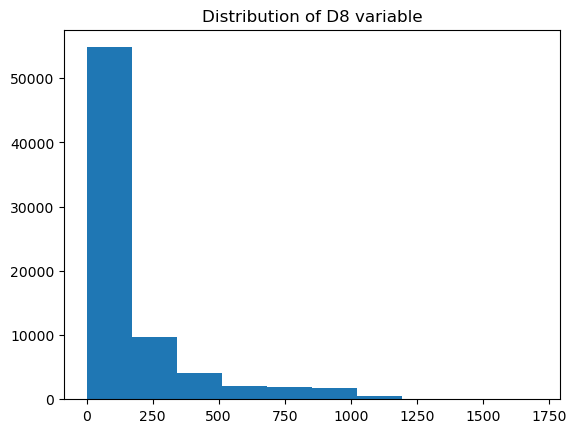

In [38]:
plt.hist(train['D8']);
plt.title('Distribution of D8 variable');

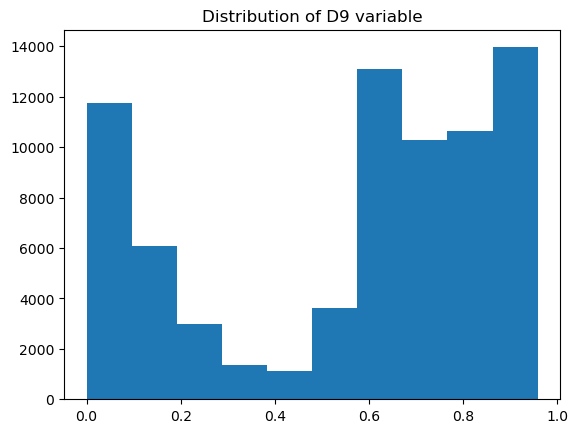

In [39]:
plt.hist(train['D9']);
plt.title('Distribution of D9 variable');

In [40]:
train.D1.value_counts()

0.0      280130
1.0        8634
2.0        4969
3.0        3954
4.0        3570
7.0        3455
6.0        3164
5.0        3076
14.0       2979
8.0        2637
28.0       2634
9.0        2387
13.0       2369
42.0       2294
15.0       2222
11.0       2119
10.0       2115
12.0       2071
29.0       2039
21.0       2023
35.0       1964
16.0       1853
30.0       1812
27.0       1791
22.0       1715
20.0       1709
18.0       1707
17.0       1656
43.0       1623
26.0       1607
32.0       1584
19.0       1568
31.0       1549
23.0       1535
56.0       1499
25.0       1440
24.0       1434
36.0       1373
34.0       1368
33.0       1343
63.0       1337
41.0       1295
37.0       1221
55.0       1220
62.0       1206
49.0       1201
57.0       1200
91.0       1192
40.0       1162
70.0       1157
39.0       1130
38.0       1118
61.0       1105
48.0       1095
59.0       1094
60.0       1083
58.0       1079
84.0       1071
44.0       1068
50.0       1007
45.0       1002
54.0        994
64.0    

In [41]:
train.D2.value_counts()

0.0      15124
1.0       6654
2.0       4454
3.0       3677
4.0       3344
7.0       3331
6.0       3068
5.0       2972
14.0      2919
8.0       2593
28.0      2582
13.0      2347
9.0       2327
42.0      2272
15.0      2148
10.0      2066
12.0      2033
11.0      2032
29.0      2011
21.0      1991
35.0      1949
16.0      1847
27.0      1762
30.0      1749
22.0      1659
18.0      1637
20.0      1634
17.0      1622
26.0      1611
31.0      1567
32.0      1559
43.0      1552
19.0      1542
23.0      1531
56.0      1499
25.0      1452
24.0      1422
36.0      1374
34.0      1355
63.0      1332
33.0      1320
41.0      1277
37.0      1194
49.0      1185
57.0      1172
55.0      1171
62.0      1158
70.0      1151
40.0      1144
91.0      1139
39.0      1100
38.0      1084
59.0      1069
48.0      1066
60.0      1058
44.0      1055
58.0      1049
61.0      1042
84.0      1027
45.0       988
50.0       978
54.0       967
64.0       957
51.0       956
46.0       953
47.0       949
69.0      

In [42]:
train.D3.value_counts()

0.0      73094
1.0      21258
2.0      13789
7.0      13320
3.0      10786
4.0       9552
14.0      9547
6.0       9245
5.0       8800
8.0       8092
13.0      6225
9.0       5947
15.0      5518
10.0      5298
28.0      5272
11.0      5126
12.0      5101
16.0      4043
21.0      3889
29.0      3634
17.0      3500
30.0      3370
20.0      3306
27.0      3062
18.0      2990
22.0      2987
19.0      2929
31.0      2799
23.0      2531
26.0      2485
32.0      2415
24.0      2332
25.0      2304
35.0      2076
33.0      2059
34.0      1877
42.0      1470
36.0      1387
37.0      1160
41.0      1124
38.0      1045
40.0      1009
43.0      1006
39.0       989
56.0       924
49.0       851
44.0       827
57.0       796
45.0       756
55.0       755
48.0       748
63.0       742
50.0       716
62.0       705
47.0       699
46.0       689
51.0       670
59.0       667
58.0       666
61.0       652
54.0       614
60.0       612
52.0       593
53.0       587
70.0       583
64.0       540
71.0      

In [43]:
train.D4.value_counts()

 0.0      166571
 1.0        5315
 2.0        3385
 3.0        2572
 4.0        2354
 7.0        2317
 5.0        2172
 14.0       2117
 6.0        2038
 8.0        1780
 28.0       1626
 9.0        1548
 13.0       1541
 15.0       1473
 12.0       1435
 11.0       1420
 10.0       1417
 21.0       1361
 29.0       1286
 16.0       1269
 27.0       1171
 20.0       1152
 26.0       1142
 18.0       1131
 30.0       1130
 35.0       1127
 22.0       1098
 17.0       1077
 42.0       1051
 23.0       1014
 25.0       1001
 19.0        988
 31.0        972
 24.0        967
 32.0        958
 34.0        947
 56.0        946
 33.0        912
 63.0        877
 49.0        873
 36.0        862
 43.0        847
 57.0        824
 55.0        820
 62.0        793
 41.0        793
 70.0        781
 40.0        780
 37.0        779
 59.0        758
 38.0        740
 39.0        739
 48.0        729
 58.0        725
 91.0        724
 50.0        722
 61.0        707
 44.0        698
 84.0        6

In [44]:
train.D5.value_counts()

0.0      65377
1.0      15282
2.0      10244
7.0       9734
3.0       7987
14.0      7340
4.0       7176
6.0       6907
5.0       6696
8.0       6140
13.0      4774
9.0       4620
15.0      4366
10.0      4130
12.0      3993
28.0      3899
11.0      3892
16.0      3147
21.0      3143
17.0      2759
29.0      2691
20.0      2632
30.0      2512
27.0      2400
19.0      2396
18.0      2384
22.0      2358
31.0      2112
23.0      2060
26.0      2016
24.0      1892
25.0      1855
32.0      1843
35.0      1681
33.0      1588
34.0      1489
42.0      1283
36.0      1169
37.0      1047
41.0      1013
43.0       932
38.0       928
40.0       905
39.0       892
56.0       846
49.0       844
57.0       758
44.0       728
55.0       723
48.0       722
45.0       708
63.0       693
47.0       652
50.0       651
62.0       643
58.0       643
59.0       643
46.0       642
61.0       612
51.0       610
60.0       578
53.0       574
52.0       573
54.0       573
70.0       553
64.0       506
69.0      

In [45]:
train.D6.value_counts()

 0.0      45782
 1.0       1588
 256.0      895
 2.0        855
 3.0        642
 4.0        579
 5.0        436
 7.0        380
 6.0        353
 249.0      344
 8.0        288
 9.0        258
 14.0       245
 10.0       231
 13.0       215
 15.0       190
 12.0       189
 11.0       186
 16.0       169
 365.0      158
 22.0       153
 21.0       150
 18.0       135
 17.0       129
 19.0       129
 29.0       120
 20.0       120
 55.0       118
 26.0       116
 364.0      107
 27.0       105
 366.0      101
 32.0       100
 35.0        98
 31.0        97
 25.0        96
 63.0        94
 257.0       93
 39.0        90
 28.0        88
 24.0        88
 363.0       88
 23.0        87
 49.0        86
 40.0        83
 42.0        81
 56.0        80
 79.0        80
 57.0        80
 33.0        80
 371.0       79
 269.0       75
 54.0        75
 367.0       74
 46.0        74
 67.0        74
 362.0       73
 84.0        73
 369.0       70
 47.0        70
 43.0        69
 77.0        68
 370.0  

In [46]:
train.D7.value_counts()

0.0      21135
1.0       1717
2.0        998
3.0        791
7.0        606
4.0        601
5.0        513
6.0        435
8.0        387
9.0        300
14.0       277
10.0       260
12.0       240
11.0       230
13.0       230
15.0       204
16.0       180
21.0       180
17.0       152
20.0       144
19.0       141
28.0       138
22.0       134
27.0       125
365.0      120
18.0       117
23.0       116
29.0       115
26.0       103
24.0       100
42.0        91
32.0        89
35.0        89
364.0       85
31.0        84
30.0        80
33.0        78
25.0        74
34.0        74
36.0        74
37.0        72
38.0        72
48.0        69
41.0        67
43.0        67
49.0        65
40.0        64
39.0        63
366.0       61
46.0        60
47.0        59
55.0        59
57.0        59
63.0        57
45.0        56
51.0        56
44.0        54
56.0        53
362.0       51
50.0        51
363.0       50
71.0        49
53.0        46
368.0       46
367.0       45
59.0        43
70.0      

In [47]:
train.D8.value_counts()

0.791503906250000       1351
0.833496093750000       1327
0.875000000000000       1304
0.958496093750000       1300
0.916503906250000       1259
0.750000000000000       1248
0.708496093750000       1175
0.083312988281250       1118
0.666503906250000       1097
0.125000000000000       1028
0.041656494140625        973
0.166625976562500        877
0.000000000000000        835
0.625000000000000        815
0.208374023437500        686
0.583496093750000        677
0.250000000000000        381
1.000000000000000        373
0.541503906250000        353
0.291748046875000        267
0.500000000000000        234
27.000000000000000       201
0.458251953125000        182
1.041992187500000        177
26.625000000000000       162
0.333251953125000        154
26.578125000000000       146
26.953125000000000       132
1.708007812500000        121
1.125000000000000        118
1.750000000000000        111
1.166992187500000        110
1.833007812500000        109
0.416748046875000        109
1.666992187500

In [48]:
train.D9.value_counts()

0.791503906250000    5388
0.833496093750000    5273
0.750000000000000    5147
0.708496093750000    5132
0.666503906250000    5069
0.875000000000000    4857
0.916503906250000    4694
0.958496093750000    4411
0.625000000000000    4380
0.000000000000000    4190
0.041656494140625    3826
0.083312988281250    3726
0.583496093750000    3644
0.125000000000000    3308
0.166625976562500    2786
0.541503906250000    2327
0.208374023437500    1913
0.500000000000000    1278
0.250000000000000    1067
0.458251953125000     733
0.291748046875000     663
0.416748046875000     404
0.333251953125000     387
0.375000000000000     323
Name: D9, dtype: int64

In [49]:
train.D10.value_counts()

0.0      221930
1.0        5186
2.0        3482
3.0        2756
7.0        2740
14.0       2512
5.0        2377
28.0       2346
4.0        2344
6.0        2303
8.0        2052
13.0       1892
15.0       1796
9.0        1769
21.0       1766
10.0       1733
29.0       1729
12.0       1687
11.0       1666
30.0       1599
16.0       1538
27.0       1472
20.0       1441
17.0       1407
22.0       1401
35.0       1392
23.0       1389
42.0       1382
26.0       1368
18.0       1333
31.0       1328
19.0       1321
56.0       1312
32.0       1273
25.0       1242
24.0       1217
34.0       1200
253.0      1178
36.0       1162
33.0       1159
43.0       1124
41.0       1112
63.0       1106
49.0       1056
61.0       1051
70.0       1049
37.0       1006
57.0       1004
62.0        991
38.0        979
91.0        978
55.0        977
58.0        976
60.0        970
39.0        964
50.0        950
48.0        946
59.0        944
40.0        935
84.0        928
44.0        886
45.0        880
69.0    

In [50]:
train.D11.value_counts()

 0.0      112281
 1.0        3165
 2.0        2020
 3.0        1642
 7.0        1639
 14.0       1496
 4.0        1449
 6.0        1440
 5.0        1424
 28.0       1313
 8.0        1245
 13.0       1139
 9.0        1107
 29.0       1072
 15.0       1063
 11.0       1011
 21.0        991
 12.0        978
 10.0        975
 20.0        893
 30.0        882
 16.0        869
 27.0        837
 26.0        823
 22.0        819
 35.0        812
 42.0        812
 56.0        798
 23.0        775
 17.0        772
 24.0        770
 19.0        755
 34.0        750
 18.0        749
 32.0        748
 31.0        741
 33.0        730
 25.0        718
 49.0        684
 41.0        678
 36.0        673
 63.0        673
 43.0        669
 62.0        637
 70.0        636
 57.0        635
 58.0        617
 40.0        610
 37.0        605
 55.0        588
 38.0        584
 59.0        581
 61.0        576
 50.0        572
 60.0        570
 91.0        564
 39.0        559
 44.0        552
 84.0        5

In [51]:
train.D12.value_counts()

 0.0      42756
 1.0       1526
 2.0        818
 3.0        634
 4.0        564
 5.0        418
 7.0        373
 6.0        341
 8.0        273
 9.0        249
 14.0       241
 10.0       218
 13.0       203
 12.0       182
 15.0       177
 11.0       169
 16.0       159
 21.0       143
 22.0       141
 18.0       135
 17.0       122
 19.0       122
 29.0       116
 20.0       114
 26.0       107
 27.0       107
 55.0       104
 35.0        93
 25.0        92
 31.0        92
 63.0        91
 28.0        87
 23.0        83
 32.0        80
 49.0        78
 56.0        76
 40.0        75
 24.0        73
 57.0        72
 269.0       72
 54.0        71
 42.0        71
 46.0        70
 47.0        69
 67.0        68
 84.0        67
 39.0        66
 43.0        65
 33.0        64
 79.0        63
 38.0        61
 65.0        59
 77.0        58
 50.0        55
 45.0        55
 37.0        55
 58.0        54
 36.0        54
 366.0       53
 125.0       53
 30.0        53
 48.0        52
 59.0   

In [52]:
train.D13.value_counts()

0.0      48840
1.0       1097
26.0       891
2.0        623
3.0        476
4.0        366
19.0       343
5.0        316
7.0        303
6.0        262
9.0        203
8.0        192
14.0       172
10.0       161
15.0       151
11.0       147
13.0       147
27.0       135
20.0       129
16.0       129
21.0       123
12.0       112
29.0       101
17.0       100
22.0        99
18.0        92
28.0        87
23.0        79
42.0        76
35.0        75
24.0        66
37.0        62
30.0        61
49.0        59
45.0        59
40.0        56
77.0        56
41.0        54
31.0        54
57.0        54
47.0        53
56.0        52
25.0        52
43.0        52
67.0        52
55.0        51
36.0        48
32.0        48
33.0        48
63.0        46
50.0        46
88.0        44
54.0        44
64.0        43
44.0        43
48.0        43
39.0        42
38.0        42
60.0        41
46.0        40
92.0        40
34.0        39
70.0        39
65.0        39
58.0        38
62.0        37
68.0      

In [53]:
train.D14.value_counts()

 0.0      45266
 1.0       1105
 256.0      658
 2.0        495
 3.0        307
 249.0      284
 4.0        260
 7.0        233
 5.0        210
 6.0        183
 8.0        158
 9.0        132
 14.0       108
 10.0       106
 13.0        91
 15.0        90
 11.0        89
 257.0       77
 28.0        66
 396.0       64
 12.0        63
 17.0        61
 16.0        60
 365.0       58
 22.0        57
 19.0        57
 50.0        56
 18.0        56
 34.0        56
 250.0       55
 49.0        55
 21.0        55
 364.0       55
 36.0        52
 41.0        52
 71.0        52
 29.0        51
 98.0        50
 413.0       50
 251.0       50
 23.0        49
 33.0        49
 386.0       48
 30.0        47
 31.0        47
 35.0        47
 370.0       47
 367.0       47
 24.0        46
 262.0       45
 60.0        44
 27.0        44
 20.0        44
 361.0       44
 385.0       43
 97.0        43
 87.0        42
 99.0        42
 62.0        42
 26.0        42
 366.0       42
 324.0       41
 43.0   

In [54]:
train.D15.value_counts()

 0.0      174246
 1.0        5936
 2.0        3691
 3.0        2878
 7.0        2577
 4.0        2573
 5.0        2336
 6.0        2276
 14.0       2265
 8.0        1973
 28.0       1869
 13.0       1791
 9.0        1735
 15.0       1651
 10.0       1615
 12.0       1588
 11.0       1545
 21.0       1487
 29.0       1469
 16.0       1357
 30.0       1327
 20.0       1288
 17.0       1287
 35.0       1276
 22.0       1267
 27.0       1265
 18.0       1241
 26.0       1213
 19.0       1205
 42.0       1196
 23.0       1175
 24.0       1152
 56.0       1149
 31.0       1140
 32.0       1138
 25.0       1091
 33.0       1071
 63.0       1063
 34.0       1025
 43.0       1012
 49.0        992
 41.0        990
 36.0        972
 55.0        963
 70.0        926
 62.0        924
 37.0        903
 57.0        898
 39.0        896
 58.0        896
 91.0        890
 38.0        885
 61.0        884
 40.0        872
 84.0        867
 50.0        865
 48.0        852
 60.0        839
 44.0        8

In [55]:
# 데이터를 잘라내고 null이 아닌 D9 데이터를 표시하는 새 열을 만든다
for df in [train, test]:
    for col in ['D'+str(i) for i in range(1,16)]:
        df[col] = df[col].clip(0)
        
    df['D9_not_na'] = np.where(df['D9'].isna(), 0, 1)
    df['D8_not_same_day'] = np.where(df['D8'] >= 1, 1, 0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

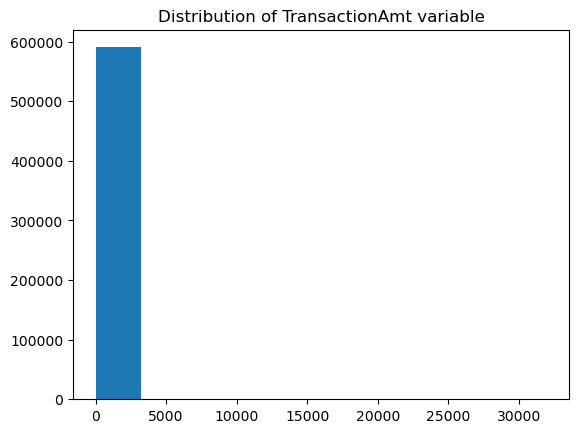

In [56]:
plt.hist(train['TransactionAmt']);
plt.title('Distribution of TransactionAmt variable');

In [57]:
np.percentile(train['TransactionAmt'], 99)

1104.0

In [58]:
# 값을 잘라낸다
train['TransactionAmt'] = train['TransactionAmt'].clip(0, 5000)
test['TransactionAmt'] = test['TransactionAmt'].clip(0, 5000)

# 정상 금액인지 아닌지 조사
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check'] = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

In [59]:
# 중재 항목 생성
for df in [train, test]:
    df['ProductCD_card1'] = df['ProductCD'].astype(str) + '_' + df['card1'].astype(str)
    df['card1_addr1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)
    df['TransactionAmt_dist2'] = df['TransactionAmt'].astype(str) + '_' + df['dist2'].astype(str)
    df['card3_card5'] = df['card3'].astype(str) + '_' + df['card5'].astype(str)
    df['ProductCD_TransactionAmt'] = df['ProductCD'].astype(str) + '_' + df['TransactionAmt'].astype(str)
    df['cents'] = np.round(df['TransactionAmt'] - np.floor(df['TransactionAmt']), 3)
    df['ProductCD_cents'] = df['ProductCD'].astype(str) + '_' + df['cents'].astype(str)
    df['TransactionAmt'] = np.log1p(df['TransactionAmt'])

In [60]:
df.ProductCD_card1.value_counts()

W_7919     13037
C_15885    12326
W_9500     11279
W_17188     8401
W_15066     5463
           ...  
W_12586        1
C_9690         1
R_9561         1
W_14720        1
W_2440         1
Name: ProductCD_card1, Length: 20656, dtype: int64

In [61]:
df.card1_addr1.value_counts()

15885_nan      11533
17188_299.0     5530
12695_325.0     4533
3154_nan        4391
9633_nan        4388
               ...  
4100_315.0         1
15988_226.0        1
12177_170.0        1
12850_476.0        1
16621_177.0        1
Name: card1_addr1, Length: 37621, dtype: int64

In [62]:
df.TransactionAmt_dist2.value_counts()

59.0_nan           27373
117.0_nan          25804
107.9375_nan       20256
57.9375_nan        20066
100.0_nan          14639
                   ...  
18.5_146.0             1
5.65625_17.0           1
9.46875_78.0           1
17.453125_73.0         1
12.171875_157.0        1
Name: TransactionAmt_dist2, Length: 23013, dtype: int64

In [63]:
df.ProductCD_TransactionAmt.value_counts()

W_59.0           27365
W_117.0          25802
W_107.9375       20243
W_57.9375        20063
W_49.0           14227
W_226.0          11090
R_100.0          10227
W_39.0            9919
W_29.0            9007
H_50.0            8658
W_47.9375         8230
W_35.9375         7558
W_171.0           7272
W_77.0            6653
W_34.0            6350
W_30.953125       6290
W_25.953125       6288
W_335.0           5451
H_100.0           5328
W_210.0           5250
R_150.0           5127
R_200.0           4933
W_67.9375         4713
W_97.0            4526
H_25.0            4090
W_58.9375         3960
W_160.0           3959
W_92.0            3742
W_108.9375        3591
R_50.0            3085
R_250.0           2969
W_82.9375         2900
W_280.0           2740
W_554.0           2663
W_445.0           2371
W_312.0           2362
W_141.0           2228
W_87.0            2180
W_87.9375         2119
H_75.0            2094
H_150.0           1954
W_108.5           1843
W_44.0            1829
S_50.0     

In [64]:
df.TransactionAmt.value_counts()

4.094344615936279    27373
4.770684719085693    25805
4.690774440765381    20256
4.076477527618408    20066
4.615120410919189    17568
3.931825637817383    14470
3.912023067474365    14235
5.424950122833252    11090
3.688879489898682     9926
3.401197433471680     9021
3.890543937683105     8233
5.017279624938965     7992
3.609227180480957     7559
5.147494316101074     7273
3.258096456527710     6779
4.356709003448486     6660
3.555348157882690     6388
5.303304672241211     6343
3.294099330902100     6294
3.464269876480103     6290
5.817111015319824     5452
5.351858139038086     5252
4.233200073242188     4722
4.584967613220215     4550
4.330733299255371     4186
5.081404209136963     3980
4.093302249908447     3961
4.532599449157715     3763
5.525453090667725     3647
4.699912071228027     3599
3.433987140655518     2941
4.430072307586670     2904
2.772588729858398     2783
5.638354778289795     2745
6.318968296051025     2663
6.100318908691406     2371
5.746203422546387     2362
3

In [65]:
test['ProductCD_card1']

0         W_10409
1          W_4272
2          W_4476
3         W_10989
4         W_18018
           ...   
506686    C_13832
506687     C_3154
506688    W_16661
506689    W_16621
506690     C_5713
Name: ProductCD_card1, Length: 506691, dtype: object

In [66]:
# 사용이 끝난 데이터는 드랍
train = train.drop(['DaysFromStart','D1-DaysFromStart'], axis=1)
test = test.drop(['DaysFromStart','D1-DaysFromStart'], axis=1)

In [74]:
for df in [train, test]:
    df['DT'] = df['TransactionDT'].apply(lambda x: (start_date+datetime.timedelta(seconds=x)))
    df['DT_M'] = ((df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year - 2017) * 52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year - 2017) * 365 + df['DT'].dt.dayofyear).astype(np.int16)
    
    df['DT_hour'] = df['DT'].dt.hour.astype(np.int8)
    df['DT_day_week'] = df['DT'].dt.dayofweek.astype(np.int8)
    df['DT_day_month'] = df['DT'].dt.day.astype(np.int8)
    
    # 잠재적 솔로 항목
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = (df['is_december'] == 12).astype(np.int8)

### Validation : 유효성 검사

- 데이터에 날짜가 있으므로 시계열 검증을 사용한다
- 학습을 위해 80% 데이터를, 유효성 검사를 위해 20% 데이터를 나눈다
- 신뢰성 보장을 위해 다양한 랜덤 시드로 여러 모델을 훈련시키고 점수를 평균화한다

In [75]:
y = train['isFraud']
X = train.drop(['isFraud'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [68]:
# 메모리 해제
# del train
# import gc
# gc.collect()

In [76]:
def freq_encode_full(df1, df2, col, normalize=True):
    """
    Encode

    https://www.kaggle.com/cdeotte/high-scoring-lgbm-malware-0-702-0-775
    """
    df = pd.concat([df1[col], df2[col]])
    freq_dict = df.value_counts(dropna=False, normalize=normalize).to_dict()
    col_name = col + '_freq_enc_full'
    return col_name, freq_dict

In [77]:
def process_data(df_train: pd.DataFrame, df_test: pd.DataFrame):
    # 제자리에서 변경되지 않도록 복사하십시오.
    train_df = df_train.copy()
    test_df = df_test.copy()
    remove_features = ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week',
                       'DT_day_month',
                       'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid',
                       'D5_DT_W_std_score',
                       'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score',
                       'D11_DT_W_std_score',
                       'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score',
                       'card3_card5_DT_D', 'ProductCD_cents_DT_D',
                       'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist',
                       'D10_DT_W_std_score', 'D8_DT_D_std_score',
                       'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score',
                       'ProductCD_TransactionAmt']

    """
     다음 코드는 다음을 수행합니다.
     * 학습 및 테스트 데이터에서 특정 열의 값을 결합하고 'value_counts'계산
     *`valid_card`를 하나 이상의 값이 있는 카테고리로 정의
     * 트레인 데이터의 열 범주도 테스트 데이터에 있으면 유지하고, 그렇지 않으면 None으로 바꿉니다.
     * 트레인 데이터의 열 범주가`valid_card`에 있으면 유지하고, 그렇지 않으면 None으로 바꿉니다.
     * 테스트 데이터에 대해 동일하게 수행
    """
    for col in ['card1', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2']:
        valid_card = pd.concat([train_df[[col]], test_df[[col]]])
        valid_card = valid_card[col].value_counts()

        valid_card = valid_card[valid_card > 2]
        valid_card = list(valid_card.index)

        train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
        train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)

        test_df[col] = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)
        test_df[col] = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    # 이전과 같이 값이 하나의 데이터 세트에만있는 경우 None으로 바꿉니다
    for col in ['card2', 'card3', 'card4', 'card5', 'card6']:
        train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
        test_df[col] = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    ####### 투레인 데이터에서 지난달의 최대 값으로 C 열을 자릅니다.
    i_cols = ['C' + str(i) for i in range(1, 15)]
    for df in [train_df, test_df]:
        for col in i_cols:
            max_value = train_df[train_df['DT_M'] == train_df['DT_M'].max()][col].max()
            df[col] = df[col].clip(None, max_value)

    ####### V feature - NaN group agg
    # null 값과 열 목록을 포함하는 dictionary가 됩니다.
    nans_groups = {}
    nans_df = pd.concat([train_df, test_df]).isna()

    i_cols = ['V' + str(i) for i in range(1, 340)]
    for col in i_cols:
        # NaN 값을 세워 봅니다
        cur_group = nans_df[col].sum()
        if cur_group > 0:
            try:
                nans_groups[cur_group].append(col)
            except:
                nans_groups[cur_group] = [col]

    for i, (n_group, n_cols) in enumerate(nans_groups.items()):
        for df in [train_df, test_df]:
            df[f'nan_group_{i}_sum'] = df[n_cols].sum(axis=1)
            df[f'nan_group_{i}_mean'] = df[n_cols].mean(axis=1)
            df[f'nan_group_{i}_std'] = df[n_cols].std(axis=1)

    del nans_groups, nans_df
    remove_features += i_cols
    # 너무나 많은 공간을 차지합니다. 필요한 것만 남기고 drop 시킵니다.
    i_cols = [i for i in i_cols if i not in ['V258', 'V306', 'V307', 'V308', 'V294']]
    train_df = train_df.drop(i_cols, axis=1)
    test_df = test_df.drop(i_cols, axis=1)

    # frequency encoding. 인코딩한 항목과 오리지날 항목을 `remove_features`에 더합니다
    i_cols = [
        'ProductCD_TransactionAmt', 'ProductCD_cents', 'cents',
        'DeviceInfo', 'DeviceInfo_device', 'DeviceInfo_version',
        'id_30', 'id_30_device', 'id_30_version',
        'id_31', 'id_31_device',
        'id_33',
    ]
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    # 원래 항목을 유지하면서 frequency encoding을 합니다. 
    i_cols = ['id_01', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13',
              'id_14', 'id_17', 'id_18', 'id_19', 'id_20',
              'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'card1', 'card2', 'card3', 'card5', 'ProductCD_card1',
              'card1_addr1', 'TransactionAmt_dist2']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    return train_df, test_df, remove_features

In [78]:
%%time
X_train, X_val, remove_features = process_data(X_train, X_val)

Wall time: 36.6 s


### Feature engineering
- 피쳐 엔지니어링

In [72]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    train_df = df_train.copy()
    test_df = df_test.copy()

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            # fit으로 학습시킨다
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)

    feature_columns = [col for col in list(train_df) if col not in remove_features]
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    print(f'train.shape : {train_df[feature_columns].shape}, test.shape : {test_df[feature_columns].shape}')

    return train_df[feature_columns], test_df[feature_columns], categorical_features


In [79]:
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

### Training the model
- 모델을 트레인하고 접근법을 검증할 함수를 만든다
- 테이블형 데이터는 그래디언트 부스팅 모델로 많이 분석한다.
- LightGBM 을 사용해서 해보자.
- LightGBM : 트리 기반 학습 알고리즘인 Gradient Boosting 프레임 워크
- LightGBM은 데이터가 적을 경우 과적합되는 경향이 있으므로 대용량 데이터일 때 주로 사용한다. (10000개 이상의 행이 있는 데이터)

In [80]:
lgb_params = {
    'objective':'binary',
    'metric':'None',
    'learning_rate':0.01,
    'num_leavers':2**8,
    'max_bin':255,
    'max_depth':-1,
    'bagging_freq':5,
    'bagging_fraction':0.7,
    'bagging_seed':seed,
    'feature_fraction':0.7,
    'feature_fraction_seed':seed,
    'first_metric_only':True,
    'verbose':100,
    'n_jobs':-1,
    'seed':seed,
}

In [83]:
@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1-y_i)
        auc += y_i * nfalse
    auc /= (nfalse*(n-nfalse))
    return auc

# 사용자 평가 함수
# @jit == just in time

def eval_auc(y_pred, y_true):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true.get_label(), y_pred), True

In [84]:
def make_val_prediction(X_train, y_train, X_val, y_val, seed=0, seed_range=3, lgb_params=None, category_cols=None):
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    auc_scores = []
    best_iterations = []
    val_preds = np.zeros((X_val.shape[0], 3))
    
    feature_importance_df = pd.DataFrame()
    feature_importance_df['feature'] = X_train.columns.tolist()
    feature_importance_df['gain_importance'] = 0
    
    for i, s in enumerate(range(seed, seed+seed_range)):
        seed_everything(s)
        params = lgb_params.copy()
        params['seed'] = s
        params['bagging_seed'] = s
        params['feature_fraction_seed'] = s
        
        clf = lgb.train(params, train_data, 10000, valid_sets=[train_data, val_data], categorical_feature=categorical_features, early_stopping_rounds=500, feval=eval_auc, verbose_eval=200)
        best_iteration = clf.best_iteration
        best_iterations.append(best_iteration)
        val_pred = clf.predict(X_val, best_iteration)
        val_preds[:, i] = val_pred
        
        auc = fast_auc(y_val, val_pred)
        auc_scores.append(auc)
        print('seed:',s,', auc:',auc,', best_iteration:', best_iteration)
        
        feature_importance_df['gain_importance'] += clf.feature_importance('gain') / seed_range
    auc_scores = np.array(auc_scores)
    best_iterations = np.array(best_iterations)
    best_iteration = int(np.mean(best_iterations))
    
    avg_pred_auc = fast_auc(y_val, np.mean(val_preds, axis=1))
    print(f'avg pred auc: {avg_pred_auc:.5f}, avg auc: {np.mean(auc_scores):.5f}+/-{np.std(auc_scores):.5f}, avg best iteration: {best_iteration}')
    feature_importance_df = feature_importance_df.sort_values(by='gain_importance', ascending=False).reset_index(drop=True)
    plt.figure(figsize=(16,12));
    sns.barplot(x="gain_importance", y="feature", data=feature_importance_df[:50])
    plt.title('LGB Features (avg over folds)');
    
    return feature_importance_df, best_iteration, val_preds

[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.842514
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.559615
[LightGBM] [Debug] init for col-wise cost 0.089320 seconds, init for row-wise cost 0.209966 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22416
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 178
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784
[LightGBM] [Debug] Re-bagging, using 330838 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331176 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330165 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330745 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330556 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330503 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330705 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330359 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330705 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330300 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330708 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330672 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330793 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330758 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330895 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330236 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 21
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330903 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330237 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330599 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 330451 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330558 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330469 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330558 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330756 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330376 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330712 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331311 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330322 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330346 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330376 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330656 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330519 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330435 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330567 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330672 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330457 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330547 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330674 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330872 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330171 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330542 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331057 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[1800]	training's auc: 0.969424	valid_1's auc: 0.91834
[LightGBM] [Debug] Re-bagging, using 330406 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330602 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330334 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331047 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330616 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 331005 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Re-bagging, using 331038 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331155 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330957 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tre

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330672 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330817 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330768 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330966 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330426 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330809 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331358 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330708 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330393 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330305 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330335 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330540 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330802 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330308 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330628 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330926 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330594 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330748 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330447 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330813 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330803 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330961 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330923 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 330644 data to train
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Debug] Re-bagging, using 330977 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330571 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331023 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[3400]	training's auc: 0.985017	valid_1's auc: 0.924871
[LightGBM] [Debug] Re-bagging, using 331012 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330676 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330570 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330534 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330752 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330234 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331714 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330878 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330941 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330728 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330810 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 329914 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330320 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330942 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330502 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330509 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 331057 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tr

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331085 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331155 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330304 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330664 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330960 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330319 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330931 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330669 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331086 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330723 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330444 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330819 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330510 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330400 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330944 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330539 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330377 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330863 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging,

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330923 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330928 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330580 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[5000]	training's auc: 0.992007	valid_1's auc: 0.927915
[LightGBM] [Debug] Re-bagging, using 330070 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330966 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330149 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330628 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330855 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Re-bagging, using 330546 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330480 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331268 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330807 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330384 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tr

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330719 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 330565 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330716 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330390 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330853 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330836 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330568 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330698 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330547 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330872 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330805 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331385 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330520 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330475 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330303 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330125 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330752 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330569 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330197 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330648 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331106 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330680 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 331393 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330434 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330430 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330923 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331039 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330606 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging,

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330838 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330747 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[6600]	training's auc: 0.995467	valid_1's auc: 0.929576
[LightGBM] [Debug] Re-bagging, using 3

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330312 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331085 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330664 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330468 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330509 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330878 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330895 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging,

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330531 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330432 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330617 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 330770 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330931 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331429 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330633 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330849 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330151 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330875 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 329933 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330265 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330852 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330188 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331106 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330483 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330552 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330817 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330960 data to train
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330791 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330854 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330250 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331148 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330703 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330750 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330960 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330904 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330873 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330846 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330907 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330793 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[8200]	training's auc: 0.997

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330586 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330257 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330932 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331067 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330665 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330962 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330421 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330479 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330097 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330269 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Re-bagging, using 330511 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331044 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330627 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330722 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331179 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330992 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330578 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330749 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330817 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330796 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330796 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330887 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 329637 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Re-bagging, using 330547 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331091 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331345 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331404 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330986 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 329931 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1000]	training's auc: 0.954236	valid_1's auc: 0.910986
[LightGBM] [Debug] Re-bagging, using 3

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330895 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330331 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330395 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330961 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330836 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330352 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330603 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330573 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330928 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330816 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330938 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330398 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330815 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Re-bagging, using 330496 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331326 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330709 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331125 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 329989 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330248 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330475 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330948 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 331428 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330693 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331025 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330322 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330979 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331233 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330851 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330717 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 330504 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330726 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331015 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330617 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330673 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging,

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330636 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330401 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330655 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330943 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[2600]	training's auc: 0.978778	valid_1's auc: 0.922629
[LightGBM] [Debug] Re-bagging, using 330897 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330630 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330635 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330844 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330960 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330546 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330753 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330634 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330471 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330654 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330536 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Re-bagging, using 330572 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330623 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330496 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330598 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330170 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330679 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330719 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330725 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330679 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330425 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330756 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330199 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330429 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 330646 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330687 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330442 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330711 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330407 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330713 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330378 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330305 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330552 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330624 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330493 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330090 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330369 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330807 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330807 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[4200]	training's auc: 0.988

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330969 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330598 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330700 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330453 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330556 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330852 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330525 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331037 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 330853 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330831 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331187 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331461 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330633 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330199 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330856 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330943 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330437 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330804 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330617 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330738 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330385 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330622 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330830 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330114 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330147 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330975 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331323 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330980 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330205 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330585 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330525 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330730 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 329926 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330678 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330518 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Re-bagging, using 330702 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330875 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330624 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330822 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331118 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[6000]	training's auc: 0.994283	valid_1's auc: 0.928823
[LightGBM] [Debug] Re-bagging, using 330795 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330485 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 3

[LightGBM] [Debug] Re-bagging, using 331291 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330254 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330556 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330646 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331117 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330591 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330558 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330702 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330817 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331023 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330481 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Re-bagging, using 330519 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330578 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330742 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330453 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330490 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330641 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330577 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330434 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330671 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330929 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331149 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 329986 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331154 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330283 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330557 data to train
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Re-bagging, using 330605 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330423 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330928 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330789 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330974 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330592 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330409 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331181 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330303 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330449 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Re-bagging, using 331004 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331177 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330513 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330775 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[800]	training's auc: 0.946912	valid_1's auc: 0.905907
[LightGBM] [Debug] Re-bagging, using 330845 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331163 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330776 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330791 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330507 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330605 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330963 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330782 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330222 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331114 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330745 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330724 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330653 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330317 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331118 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330449 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330798 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 330828 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331092 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Re-bagging, using 330704 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330599 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330520 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330914 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330122 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330946 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331243 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331052 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330575 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330444 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331026 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331055 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330772 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330719 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330657 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tr

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330949 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330721 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331285 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330690 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330729 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330799 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330635 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330937 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[2600]	training's auc: 0.978778	valid_1's auc: 0.922572
[LightGBM] [Debug] Re-bagging, using 330909 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330005 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 33114

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330641 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330949 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330768 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330942 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330535 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330544 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330460 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330695 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330542 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331034 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging,

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330639 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330516 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330487 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330577 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330146 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330730 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330711 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330546 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330668 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330375 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330748 data to train
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330435 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330212 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tr

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330463 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331286 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330714 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330448 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330757 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 329992 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330379 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330313 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331130 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330494 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330474 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging,

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330391 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331038 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330579 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[4200]	training's auc: 0.989066	valid_1's auc: 0.926667
[LightGBM] [Debug] Re-bagging, using 330789 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330540 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330710 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330735 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330563 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331187 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330987 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 330558 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 331032 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330815 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331214 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 330808 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Re-bagging, using 330617 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330328 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330791 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330889 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331174 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330793 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330967 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331106 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Re-bagging, using 330357 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330940 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330788 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330318 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330584 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331260 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330325 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330567 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Re-bagging, using 330977 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330781 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330844 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 330531 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330542 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330536 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331139 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330422 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330441 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330683 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330622 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[5800]	training's auc: 0.993937	valid_1's auc: 0.928357
[LightGBM] [Debug] Re-bagging, using 330909 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330

[LightGBM] [Debug] Re-bagging, using 331125 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331190 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Re-bagging, using 330443 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330027 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331029 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330586 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330362 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331112 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330461 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331298 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Re-bagging, using 330550 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330664 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330846 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330472 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330659 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330755 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330885 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330497 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330556 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330428 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330576 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330795 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330835 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330940 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330839 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330756 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 331003 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330410 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330804 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330674 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330596 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330553 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331050 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331066 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330602 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330865 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330776 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[7400]	training's auc: 0.996638	valid_1's auc: 0.929254
[LightGBM] [Debug] Re-bagging, using 3

[LightGBM] [Debug] Re-bagging, using 330286 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331217 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331032 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330413 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331185 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 331028 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331077 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330981 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330326 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330338 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331123 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330875 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330833 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331610 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330991 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330531 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330303 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330520 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330547 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330799 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330737 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330472 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330881 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330832 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330502 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330501 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330913 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330438 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330721 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330686 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331116 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330725 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330634 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331064 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330598 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330743 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330960 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330574 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330441 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330534 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330660 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[9200]	training's auc: 0.99823	valid_1's auc: 0.929477
[LightGBM] [Debug] Re-bagging, using 330861 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330814 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331100 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331226 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330892 data to train
[LightGBM] [Debug] Trained a tree with 

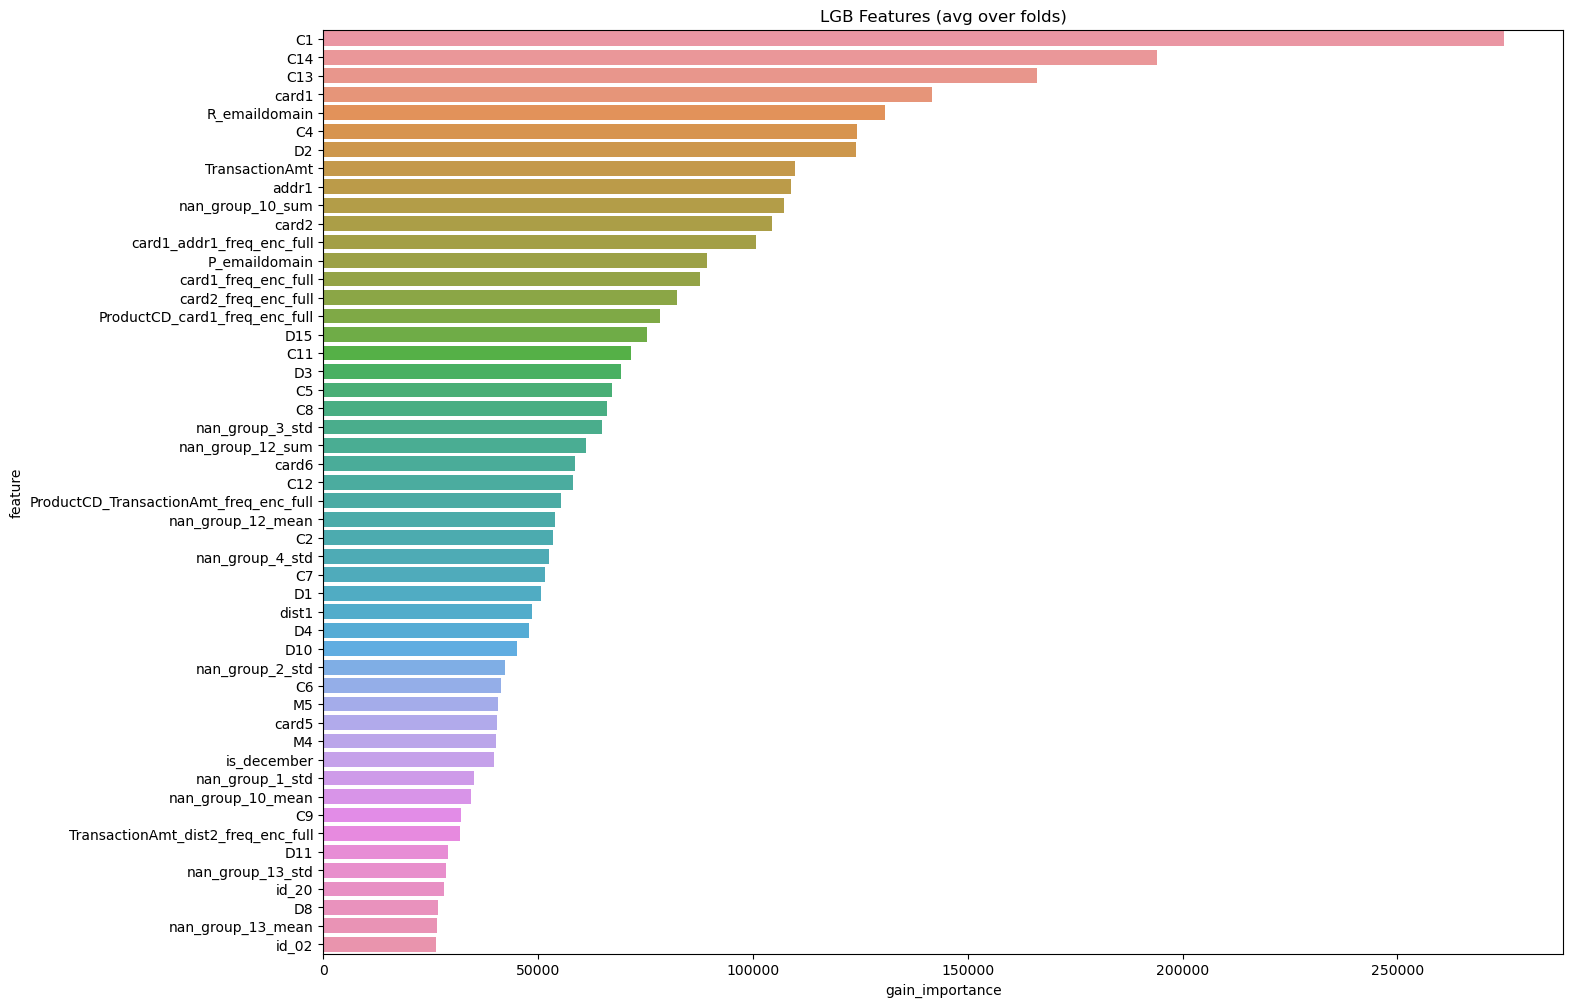

In [85]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features, lgb_params=lgb_params)

### Making Prediction

- StratifiedFold에 대한 전체 데이터에 대한 모델을 학습
- 모델에서 유효성 검사를 사용하지 않지만 과적합을 피하기 위해 고정된 수를 반복
- 훈련은 폴드에서 수행

In [86]:
def prediction(X, y, X_test, best_iteration, seed=seed, category_cols=None, n_folds=5):
    print('best iteration:', best_iteration)
    preds = np.zeros((X_test.shape[0], n_folds))
    
    print(X.shape, X_test.shape)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    for i , (trn_idx, _) in enumerate(skf.split(X,y)):
        fold = i + 1
        tr_x, tr_y = X.iloc[trn_idx, :], y.iloc[trn_idx]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        clf = lgb.train(lgb_params, tr_data, best_iteration, categorical_feature=category_cols)
        preds[:,i] = clf.predict(X_test)
        
    return preds

In [88]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

In [89]:
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)

best iteration: 7740
(590540, 178) (506691, 178)
[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Info] Number of positive: 16531, number of negative: 455901
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.850027
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.564567
[LightGBM] [Debug] init for col-wise cost 0.115001 seconds, init for row-wise cost 0.222454 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23043
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 178
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034991 -> initscore=-3.317038
[LightGBM] [Info] Start training from score -3.317038
[LightGBM] [Debug] Re-bagging, using 330794 dat

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 329943 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330827 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, us

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330635 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 329654 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330473 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330881 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging,

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330730 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330755 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Re-bagging, using 330834 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330969 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330701 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330702 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330904 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330987 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331006 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330098 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330198 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330990 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330077 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330660 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330700 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330519 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330324 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330884 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330991 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330674 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330083 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330980 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331310 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331248 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330818 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330280 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330821 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331234 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330391 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330623 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331213 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330781 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331125 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 329975 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330471 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330994 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331039 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330381 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330985 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331096 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330747 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330757 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331026 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tr

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331500 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330864 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330806 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330563 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330639 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331205 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330938 data to train
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330081 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330501 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330455 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330547 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330435 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330025 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330683 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331071 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330598 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330052 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330714 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330664 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330378 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331360 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330836 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330943 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331013 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330792 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330842 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330717 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330782 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330417 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330910 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330496 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330820 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330413 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330746 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330625 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330373 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330764 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330639 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331118 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330418 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331199 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330488 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330973 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330258 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330398 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330801 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330624 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330384 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330846 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 329642 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331416 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331395 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330702 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330781 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331058 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330686 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330674 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330239 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330945 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330620 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330572 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331058 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331075 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330767 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331331 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331434 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330454 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 329888 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330925 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330288 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330182 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330431 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330878 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330737 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330475 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330592 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331042 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331052 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331101 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 330979 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330395 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330198 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331258 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330199 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330573 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330375 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330631 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331083 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330720 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330738 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330369 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331046 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330216 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331177 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330546 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330295 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330850 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330382 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Re-bagging, using 330856 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330247 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330991 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330512 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330408 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331006 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330548 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330185 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330807 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331207 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330089 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331513 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331022 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330496 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330716 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging,

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330555 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330346 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330876 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330799 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 330673 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331191 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330448 data to train
[LightGBM] [Debug] Trained a tree with leaves

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330779 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331036 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330892 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330857 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330599 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330797 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330876 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330969 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330944 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Re-bagging, using 330828 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330649 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330867 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330484 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 330608 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330951 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330368 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331299 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330299 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330562 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331003 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330921 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331018 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330375 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330648 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330867 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330663 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tre

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330289 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330763 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330795 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331213 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330525 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330581 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 329975 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330623 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Re-bagging, using 330471 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330994 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331144 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330381 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330715 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330747 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330657 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 331026 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330656 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330864 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330821 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330806 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330563 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330639 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331205 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330081 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330501 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330455 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330999 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330665 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330547 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330379 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330435 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330871 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331159 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331071 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330056 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330668 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330052 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330934 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330381 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331045 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331135 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331212 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331013 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330842 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330717 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330474 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330417 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330587 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330496 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331177 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330572 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330413 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331234 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330687 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330373 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330862 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331105 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330639 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331226 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330947 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331199 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330973 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330258 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330743 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330801 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330624 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331145 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330384 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330596 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 329642 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331395 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330702 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331058 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330732 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330674 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330239 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330620 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330572 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331075 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330787 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330767 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331331 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331434 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330454 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 329888 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330375 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330288 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330182 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330394 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330431 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330811 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330737 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330592 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331042 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331052 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331101 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330979 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330395 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330198 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331258 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330573 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330375 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330982 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330631 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330720 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330738 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330369 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330488 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331046 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330216 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330216 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331177 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330367 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330295 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging,

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330856 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 330247 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330991 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330694 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330512 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330849 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330302 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331006 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330503 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330185 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330909 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330459 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331207 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330363 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330708 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330415 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330496 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tre

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330487 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330555 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 330346 data to train
[LightGBM] [Debug] Trained a tree with leav

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330663 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330876 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained

[LightGBM] [Debug] init for col-wise cost 0.110966 seconds, init for row-wise cost 0.261235 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23057
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 178
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
[LightGBM] [Debug] Re-bagging, using 330794 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330673 da

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330827 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330594 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tre

[LightGBM] [Debug] Re-bagging, using 330635 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 329654 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330803 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330881 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 329741 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330599 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330755 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330876 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330969 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330701 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Re-bagging, using 330828 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330904 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330987 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330867 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 331006 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330098 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330198 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330990 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330077 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330660 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330700 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330324 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 330884 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330674 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330083 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330980 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331310 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330914 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330878 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330818 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330731 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330821 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331234 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 22
[LightGBM] [Debug] Re-bagging, using 330711 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330391 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330623 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331218 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 330781 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330679 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330221 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330471 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331350 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331039 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330230 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330985 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 331096 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330672 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330757 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330809 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331500 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330576 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330840 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330762 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331297 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331165 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330081 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330563 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330999 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330665 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330809 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330379 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330435 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330871 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331159 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331071 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330668 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330052 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330714 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330381 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330378 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331135 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330836 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331212 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331013 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330792 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330842 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330717 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330782 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330474 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330417 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330249 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330587 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330496 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 331177 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330572 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330413 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331234 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330687 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330862 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331105 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330639 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331226 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330947 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331199 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330813 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330973 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331021 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330851 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330743 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330801 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331145 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330583 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330616 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330462 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330655 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330698 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330779 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 329205 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330732 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331130 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330718 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330945 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330476 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331058 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331244 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331156 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330124 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331015 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330346 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330888 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330375 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330455 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330600 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330625 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330626 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330481 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 330401 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330708 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330605 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330881 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330871 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330354 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330777 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 330845 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331035 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330948 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331237 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330310 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330949 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330735 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330442 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330638 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330926 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331049 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330406 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330671 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330510 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330611 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330742 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330666 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330586 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331003 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330625 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330935 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331050 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 331195 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330236 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330687 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330682 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330830 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330485 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331467 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331046 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330704 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330775 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330700 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330714 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330790 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330758 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330631 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330862 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331153 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330727 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331256 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330603 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330859 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330963 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tre

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330744 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330299 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331041 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330454 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330729 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330871 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330377 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330746 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330832 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330666 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330986 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330367 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330669 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330550 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330747 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330223 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330634 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331227 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330212 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330486 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Re-bagging, using 330836 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330507 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331503 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330627 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330874 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330575 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330737 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330822 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330589 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331112 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331002 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330764 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330506 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330605 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330719 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330112 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330912 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 329983 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 329908 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330668 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330231 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330960 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330467 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330351 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330546 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330967 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331082 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330656 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330165 data to train
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331042 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331018 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331045 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330768 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330894 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330830 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330514 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330809 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330953 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330871 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330056 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330668 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330934 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330381 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331045 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331135 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330822 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331275 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331212 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330778 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 329812 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330639 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330292 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330474 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330622 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330249 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330587 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330702 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331177 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330900 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331234 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330687 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330505 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330862 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331105 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330747 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331226 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330472 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330813 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331021 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330851 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331002 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330801 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331145 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330616 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330596 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330655 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331395 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330702 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330779 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330732 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330674 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330945 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330620 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330476 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331058 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331075 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330767 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331331 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331015 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330454 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330888 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330375 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330288 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330625 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330394 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330431 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330468 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330811 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330708 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330605 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330592 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330871 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330354 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331052 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330845 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330440 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331237 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330199 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330573 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330982 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330631 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330733 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330720 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330330 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330488 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330813 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330929 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330216 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330742 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330578 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331003 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330825 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330501 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330652 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330752 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330885 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330662 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331248 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330849 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330667 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330821 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330495 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330809 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330909 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330363 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330708 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330546 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331149 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330714 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331065 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330487 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330249 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330916 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330663 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.849581
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.564275
[LightGBM] [Debug] init for col-wise cost 0.124470 seconds, init for row-wise cost 0.222892 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23049
[LightGBM] [Info] Number of data poin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331081 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 329943 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330466 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330635 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330473 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330881 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330730 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330755 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330834 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330969 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330701 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330702 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330904 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Re-bagging, using 330623 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331006 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330098 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330887 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330990 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330564 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330660 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330519 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330324 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Re-bagging, using 331173 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330991 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330674 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330755 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330980 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330914 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330878 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330673 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330731 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330821 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330926 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330711 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330386 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331218 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330781 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330084 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330679 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 329937 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331350 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330321 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330613 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330230 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330960 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330632 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331128 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330351 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330475 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330967 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330796 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330846 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330656 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330165 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331042 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331018 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331045 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330632 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330768 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330894 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330912 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330830 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330676 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330341 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330838 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330921 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330386 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330494 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330483 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330836 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330440 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 329979 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330609 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330822 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330179 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330935 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330986 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330525 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331152 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330635 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330803 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330509 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330669 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Re-bagging, using 330794 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330968 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330400 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331092 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330908 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330694 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331080 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330146 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330769 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 329784 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330615 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331139 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330701 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331113 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330575 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330523 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330381 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330528 data to train
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331093 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330602 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330890 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330688 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331238 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330897 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330784 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330899 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330855 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 329883 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330009 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330381 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330628 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330800 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330516 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330261 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330792 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330686 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330199 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330883 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330591 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330905 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330475 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330538 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330867 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330652 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330463 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330720 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330753 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330771 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330504 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330498 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330626 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330884 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330717 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330719 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330830 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330768 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330557 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330786 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 330130 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330787 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330394 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330802 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330855 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331081 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331211 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330732 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330418 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330983 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331015 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331040 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330649 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330548 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331110 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330957 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331215 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330332 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331131 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330676 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tr

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330641 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331102 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330559 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330819 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 329765 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330937 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330860 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330617 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331294 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331171 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330775 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331236 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330779 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tr

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330850 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330631 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330862 data to train
[LightGBM] [Debug] Trained a tree w

In [90]:
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_1_3.csv', index=False)

### More feature engineering
- D열을 작업한다
- 일정 기간이 포함된 함수를 정의하고 이 기간을 기준으로 값을 그룹화한 다음 정규화된 값을 최소/최대/평균/표준으로 계산하는 것을 만들자

In [99]:
def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period

            dt_df[col] = dt_df[col].astype(float)

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col + '_min_max'] = (dt_df[col] - dt_df['temp_min']) / (dt_df['temp_max'] - dt_df['temp_min'])
            dt_df[new_col + '_std_score'] = (dt_df[col] - dt_df['temp_mean']) / (dt_df['temp_std'])
            del dt_df['temp_min'], dt_df['temp_max'], dt_df['temp_mean'], dt_df['temp_std']
    return dt_df

In [100]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # 변경되지 않도록 복사합니다
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    # normalize by max train value
    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    # frequency encoding
    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [101]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851512
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.540885
[LightGBM] [Debug] init for col-wise cost 0.101194 seconds, init for row-wise cost 0.275607 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.317429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32293
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 223
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784
[LightGBM] [Debug] Re-bagging, using 330838 

[LightGBM] [Debug] Re-bagging, using 331176 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330165 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330745 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330556 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330503 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330705 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330359 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330705 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330300 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330708 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330672 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330850 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330793 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330758 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330895 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330236 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330903 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330237 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330451 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330558 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330469 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 331018 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330558 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330756 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330376 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330712 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330322 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330346 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330376 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330656 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330519 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330294 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330435 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330567 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330672 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330457 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330674 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330872 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330171 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330517 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330542 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331057 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[1800]	training's auc: 0.970703	valid_1's auc: 0.917323
[LightGBM] [Debug] Re-bagging, using 330406 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330602 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330334 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331047 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330616 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 331005 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331038 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331155 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330957 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330672 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330817 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330768 data to train
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Re-bagging, using 330966 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330426 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330809 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331358 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330708 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330393 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330305 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330335 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 331075 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330540 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330802 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330308 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330926 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330594 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330644 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330748 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330447 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330813 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330803 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330961 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330923 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330644 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330977 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330571 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331023 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[3400]	training's auc: 0.986338	valid_1's auc: 0.922684
[LightGBM] [Debug] Re-bagging, using 331012 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330739 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330676 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330570 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330534 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330752 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330234 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331714 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330878 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330941 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330728 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330810 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-baggi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330320 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330942 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330502 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331073 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330509 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331057 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 331385 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331085 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331155 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330664 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330960 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331003 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 330931 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330669 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330634 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331086 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330723 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330444 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 21
[LightGBM] [Debug] Re-bagging, using 330819 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330400 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330944 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330491 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330377 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330863 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330558 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330923 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330928 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Re-bagging, using 331179 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330737 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[5000]	training's auc: 0.993498	valid_1's auc: 0.925794
[LightGBM] [Debug] Re-bagging, using 330070 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leave

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330487 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330149 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330165 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330546 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330480 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 330833 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330091 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330807 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330802 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330719 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tre

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330721 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330390 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330853 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330990 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330853 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330568 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330347 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330547 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330635 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331385 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330520 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330391 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330303 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330125 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330569 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330197 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330557 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331106 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-baggin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330638 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331393 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330434 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 331146 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330430 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330923 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331039 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330606 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330838 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330747 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[6600]	training's auc: 0.996719	valid_1's auc: 0.927422
[LightGBM] [Debug] Re-bagging, using 33

[LightGBM] [Debug] Re-bagging, using 330312 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331085 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330664 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330468 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330509 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330878 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330895 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330531 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330432 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330617 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330770 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330931 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331429 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330633 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330849 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330151 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330875 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 329933 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330265 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330852 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330188 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Re-bagging, using 330681 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331106 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330483 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330552 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330817 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330791 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330854 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331439 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331148 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330703 data to train
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330750 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330960 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330614 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330873 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330784 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330907 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330793 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330657 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330586 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330257 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330149 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330666 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330325 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330989 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331153 data to train
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330772 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 329456 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330749 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331176 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330963 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 330964 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331038 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330485 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330700 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331318 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330308 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330701 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 330692 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331039 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330272 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330510 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330963 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330057 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330287 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331031 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 331180 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330488 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 331006 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330701 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331127 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330634 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 329890 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Re-bagging, using 330724 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331071 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 331332 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1400]	training's auc: 0.96363	valid_1's auc: 0.914394
[LightGBM] [Debug] Re-bagging, using 330904 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330775 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330576 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330762 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330844 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330967 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging,

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330486 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330701 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330332 data to train
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Re-bagging, using 330732 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330679 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330451 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330027 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330818 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330762 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 329723 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, u

[LightGBM] [Debug] Re-bagging, using 330656 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331072 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330402 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331185 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330911 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tre

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330672 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331373 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330883 data to train
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Debug] Re-bagging, using 330836 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330441 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330158 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330948 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330775 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330965 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330608 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330343 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330683 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330629 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331147 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Re-bagging, using 330100 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330870 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331012 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330441 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[3000]	training's auc: 0.983569	valid_1's auc: 0.921897
[LightGBM] [Debug] Re-bagging, using 331113 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330720 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330692 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330617 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 331536 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 329580 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330928 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330514 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330952 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330604 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331591 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330760 data to train
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Re-bagging, using 330423 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330993 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331206 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330721 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330743 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330246 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330765 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330543 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330618 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331051 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330538 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330617 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330573 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330571 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330865 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330680 data to train
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Re-bagging, using 330850 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330532 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330373 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330515 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330979 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330777 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330846 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330859 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330952 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331083 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 329601 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331503 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[4600]	training's auc: 0.992077	valid_1's auc: 0.925208
[LightGBM] [Debug] Re-bagging, using 33

[LightGBM] [Debug] Re-bagging, using 331265 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330491 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330664 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330837 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331165 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330840 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 330630 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330492 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330842 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330482 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Re-bagging, using 330425 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 331084 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330685 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 331299 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 331153 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 330994 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330978 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330289 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330574 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330387 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Re-bagging, using 330718 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330531 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging, using 330782 data to train
[LightGBM] [Debug] Trained a tree 

[LightGBM] [Debug] Re-bagging, using 331001 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 331167 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330804 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330907 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330430 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 330625 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330962 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330485 data to train
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Re-bagging, using 330640 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Re-bagging, using 330294 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330508 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree wit

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330814 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330659 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330800 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330463 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330801 data to train
[LightGBM] [Debug] Trained a tree w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Re-bagging, using 330313 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330680 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330535 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree wi

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[6400]	training's auc: 0.996352	valid_1's auc: 0.92704
[LightGBM] [Debug] Re-bagging, using 330932 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 330831 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 330743 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 331016 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Re-bagging, using 330692 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Re-bagging, using 330376 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 331047 data to train
[LightGBM] [Debug] Trained a tree wit

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_2.csv', index=False)

## More feature engineering 2

이제는 C-columns에 대한 피쳐 엔지니어링을 좀 해 보겠습니다

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # 원본이 변경되지 않도록 복사해 사용합니다
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    # normalize by max train value
    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    # frequency encoding
    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]
    # 여기서는 C column의 0들을 카운트합니다
    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_3.csv', index=False)

## More feature engineering - aggregations

데이터에 대한 다양한 집계를 계산합니다.

In [ ]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col + '_' + main_column + '_' + agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                    columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)
    return train_df, test_df

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # 복사해 둡니다
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]

    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    i_cols = ['TransactionAmt', 'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_14', 'dist1'] + ['C' + str(i) for i in
                                                                                                  range(1, 15)]
    uids = ['card1', 'card2', 'card3', 'card5', 'uid', 'card3_card5']
    aggregations = ['mean', 'std']

    # uIDs aggregations
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = [
                 'V258',
                 'V306', 'V307', 'V308', 'V294'
             ] + ['D' + str(i) for i in range(1, 16)]
    uids = ['uid', 'card3_card5']
    aggregations = ['mean', 'std']
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_4.csv', index=False)

### More feature engineering - time-block frequency encoding
- 이것은 일반적인 frequency 인코딩과 유사하지만 해당 기간 내에 값을 인코딩함
- 타임블록 프리퀀시 인코딩이라는 피쳐 엔지니어링을 수행한다

In [ ]:
def timeblock_frequency_encoding(train_df, test_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period
            print('timeblock frequency encoding:', new_col)
            train_df[new_col] = train_df[col].astype(str) + '_' + train_df[period].astype(str)
            test_df[new_col] = test_df[col].astype(str) + '_' + test_df[period].astype(str)

            temp_df = pd.concat([train_df[[new_col]], test_df[[new_col]]])
            fq_encode = temp_df[new_col].value_counts(normalize=True).to_dict()

            train_df[new_col] = train_df[new_col].map(fq_encode)
            test_df[new_col] = test_df[new_col].map(fq_encode)

            train_df[new_col] = train_df[new_col] / train_df[period + '_freq_enc_full']
            test_df[new_col] = test_df[new_col] / test_df[period + '_freq_enc_full']

    return train_df, test_df

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # 복사해 둡니다
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]

    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    i_cols = ['TransactionAmt', 'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_14', 'dist1'] + ['C' + str(i) for i in
                                                                                                  range(1, 15)]
    uids = ['card1', 'card2', 'card3', 'card5', 'uid', 'card3_card5']
    aggregations = ['mean', 'std']

    # uIDs aggregations
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = [
                 'V258',
                 'V306', 'V307', 'V308', 'V294'
             ] + ['D' + str(i) for i in range(1, 16)]
    uids = ['uid', 'card3_card5']
    aggregations = ['mean', 'std']
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = ['ProductCD_TransactionAmt', 'ProductCD_cents', 'ProductCD_cents', 'uid', 'card3_card5']
    periods = ['DT_D', 'DT_W']
    train_df, test_df = timeblock_frequency_encoding(train_df, test_df, periods, i_cols)

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features


In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_5.csv', index=False)